# Analysis of Graded Agent Responses

This notebook loads classification results generated by `grade.py` (JSONL files) from multiple result directories and visualizes various aspects of the data, including the distribution of rationale categories, off-topic responses, and performance metrics by agent model.

The notebook will automatically detect and process:
- Single-agent results from the `results/` directory
- Multi-agent results from the `results_multi/` directory  
- Multi-agent star topology results from the `results_multi_star/` directory
- Any other `results_*` directories found
- Generate separate visualizations for each type
- Create aggregate comparisons across all types

**Note**: If classification files are not found, the notebook will fall back to loading raw CSV files and provide analysis on the available data.

**Updated**: The notebook now handles single-agent classification files properly and provides improved data standardization.

In [36]:
import pandas as pd
import json
import os
import logging
import numpy as np
import glob
from pathlib import Path
import sys

# Add the current directory to sys.path to import analysis functions
sys.path.append(os.path.abspath('.'))

try:
    from analysis_functions import (
        load_datasets_with_fallback,
        prepare_datasets_for_analysis,
        create_combined_dataset,
        generate_summary_stats
    )
except ImportError as e:
    print(f"Error importing analysis functions: {e}")
    print("Make sure analysis_functions.py exists in the current directory")
    raise

# --- Configuration ---
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# --- Logging Setup ---
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - NOTEBOOK - %(levelname)s - %(message)s')

# --- Load Data with Fallback ---
print("=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===")
datasets, dataset_info = load_datasets_with_fallback(BASE_DIR)

# --- Prepare Data for Analysis ---
print("\n=== PREPARING DATA FOR ANALYSIS ===")
prepared_datasets = prepare_datasets_for_analysis(datasets, dataset_info)

# Add combined dataset
print("\n=== CREATING COMBINED DATASET ===")
prepared_datasets['combined'] = create_combined_dataset(prepared_datasets)

# --- Summary Statistics ---
print("\n=== DATA PREPARATION SUMMARY ===")

for data_type, data_dict in prepared_datasets.items():
    analysis_df = data_dict['analysis']
    exploded_df = data_dict['exploded']
    errors_df = data_dict['errors']
    info = data_dict['info']
    
    print(f"\n{data_type.replace('_', '-').title()}:")
    print(f"  Valid responses: {len(analysis_df)}")
    print(f"  Exploded categories: {len(exploded_df)}")
    print(f"  Processing errors: {len(errors_df)}")
    print(f"  Has classification data: {'Yes' if info['has_classification'] else 'No'}")
    print(f"  File type: {info['file_type']}")
    
    if not analysis_df.empty:
        print(f"  Unique questions: {analysis_df['question_id'].nunique() if 'question_id' in analysis_df.columns else 'N/A'}")
        
        # Check for model column in various formats
        model_col = None
        for col in ['agent_model', 'model_name', 'agent_name']:
            if col in analysis_df.columns:
                model_col = col
                break
        
        if model_col:
            print(f"  Unique models: {analysis_df[model_col].nunique()}")
        
        if not errors_df.empty and 'error_type' in errors_df.columns:
            print(f"  Error types: {errors_df['error_type'].nunique()}")

=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===

=== PREPARING DATA FOR ANALYSIS ===

=== CREATING COMBINED DATASET ===

=== DATA PREPARATION SUMMARY ===

Results-Ous-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi-Star:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Ous:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Combined:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: combined


In [37]:
# Generate and display summary statistics table
summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("=== SUMMARY STATISTICS TABLE ===")
    print(summary_df.to_string(index=False))
    
    # Check what data types we have for visualization
    datasets_with_classification = summary_df[summary_df['Has Classification'] == 'Yes']
    datasets_with_raw_data = summary_df[summary_df['Has Classification'] == 'No']
    
    print(f"\n=== DATA AVAILABILITY SUMMARY ===")
    print(f"Datasets with classification data: {len(datasets_with_classification)}")
    if not datasets_with_classification.empty:
        print("  -", ", ".join(datasets_with_classification['Dataset'].tolist()))
    
    print(f"Datasets with raw data only: {len(datasets_with_raw_data)}")
    if not datasets_with_raw_data.empty:
        print("  -", ", ".join(datasets_with_raw_data['Dataset'].tolist()))
    
    # Set up data for visualizations
    df_all = prepared_datasets['combined']['analysis']
    df_all_exploded = prepared_datasets['combined']['exploded'] 
    df_all_errors = prepared_datasets['combined']['errors']
    
    print(f"\nCombined dataset: {len(df_all)} total records")
    print(f"Combined exploded categories: {len(df_all_exploded)} records")
    print(f"Combined errors: {len(df_all_errors)} records")
    
    # Display column information for debugging
    if not df_all.empty:
        print(f"\nAvailable columns in combined analysis data:")
        print(f"  Standard columns: {[col for col in df_all.columns if col in ['question_id', 'agent_name', 'agent_model', 'extracted_answer', 'extracted_answer_numeric', 'is_response_off_topic', 'selected_categories']]}")
        print(f"  Classification columns: {[col for col in df_all.columns if 'classification' in col.lower() or col in ['off_topic_reason', 'error_type']]}")
else:
    print("No data available for analysis")
    df_all = pd.DataFrame()
    df_all_exploded = pd.DataFrame()
    df_all_errors = pd.DataFrame()

=== SUMMARY STATISTICS TABLE ===
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0

=== DATA AVAILABILITY SUMMARY ===
Datasets with classification data: 0
Datasets with raw data only: 6
  - results_ous_multi, results_multi_star, results_ous, results, results_multi, combined

Combined dataset: 0 total records
Combined exploded categories: 0 records
Combined errors: 0 records


## Visualization of Graded Rationale Classifications

The following plots visualize the distribution of classified rationale categories, off-topic responses, answer scores, and other metrics. Visualizations are generated for each discovered dataset type:

1. **Single-agent results** - Individual model responses (from `results/`)
2. **Multi-agent results** - Group conversation responses (from `results_multi/`)
3. **Multi-agent star results** - Star topology conversations (from `results_multi_star/`)
4. **Other discovered datasets** - Any additional `results_*` directories
5. **Combined analysis** - Aggregate view across all types

**Note**: Some visualizations may not be available if classification data is missing. In such cases, basic statistics will be shown instead.

**Updated**: The visualization functions now handle standardized data formats and improved category processing.

In [38]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for seaborn plots
sns.set_theme(style="whitegrid")

# --- Visualization Functions ---
def plot_category_distribution(df_exploded, title_prefix=""):
    """Plot distribution of rationale categories."""
    if df_exploded.empty or 'selected_categories' not in df_exploded.columns:
        print(f"No data available for category distribution: {title_prefix}")
        return None
    
    valid_categories = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_categories.empty:
        print(f"No valid categories found: {title_prefix}")
        return None
    
    category_counts = valid_categories['selected_categories'].value_counts().reset_index()
    category_counts.columns = ['category', 'count']
    
    fig = px.bar(category_counts, x='category', y='count',
                 title=f'{title_prefix} Distribution of Selected Rationale Categories',
                 labels={'category': 'Rationale Category', 'count': 'Frequency'},
                 height=600)
    fig.update_layout(xaxis_tickangle=-45)
    return fig

def plot_off_topic_distribution(df_analysis, title_prefix=""):
    """Plot distribution of off-topic responses."""
    if df_analysis.empty or 'is_response_off_topic' not in df_analysis.columns:
        print(f"No off-topic data available: {title_prefix}")
        return None
    
    off_topic_counts = df_analysis['is_response_off_topic'].value_counts(dropna=False).reset_index()
    off_topic_counts.columns = ['is_off_topic', 'count']
    
    fig = px.pie(off_topic_counts, names='is_off_topic', values='count',
                 title=f'{title_prefix} Distribution of Off-Topic Responses',
                 hole=0.3)
    return fig

def plot_answer_distribution(df_analysis, title_prefix=""):
    """Plot distribution of answer scores."""
    if df_analysis.empty or 'extracted_answer_numeric' not in df_analysis.columns:
        print(f"No answer score data available: {title_prefix}")
        return None
    
    valid_answers = df_analysis[df_analysis['extracted_answer_numeric'].notna()]
    if valid_answers.empty:
        print(f"No valid answer scores found: {title_prefix}")
        return None
    
    fig = px.histogram(valid_answers, x='extracted_answer_numeric',
                       title=f'{title_prefix} Distribution of Answer Scores',
                       labels={'extracted_answer_numeric': 'Answer Score'},
                       nbins=7)
    return fig

def plot_categories_by_model(df_exploded, title_prefix=""):
    """Plot categories by agent model."""
    if (df_exploded.empty or 'agent_model' not in df_exploded.columns or 
        'selected_categories' not in df_exploded.columns):
        print(f"No model/category data available: {title_prefix}")
        return None
    
    valid_data = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_data.empty:
        print(f"No valid model/category data found: {title_prefix}")
        return None
    
    categories_by_model = valid_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
    
    if categories_by_model.empty:
        print(f"No aggregated model/category data: {title_prefix}")
        return None
    
    fig = px.bar(categories_by_model, x='selected_categories', y='count',
                 color='agent_model', barmode='group',
                 title=f'{title_prefix} Rationale Categories by Agent Model',
                 labels={'selected_categories': 'Rationale Category', 'count': 'Frequency'},
                 height=700)
    fig.update_layout(xaxis_tickangle=-45)
    return fig

# --- Generate Visualizations for Each Dataset ---
for data_type, data_dict in prepared_datasets.items():
    analysis_df = data_dict['analysis']
    exploded_df = data_dict['exploded']
    
    if analysis_df.empty:
        print(f"\n=== {data_type.replace('_', ' ').upper()} VISUALIZATIONS ===")
        print(f"No data available for {data_type} visualizations")
        continue
    
    dataset_name = data_type.replace('_', '-').title()
    print(f"\n=== {dataset_name.upper()} VISUALIZATIONS ===")
    
    # 1. Category Distribution
    fig = plot_category_distribution(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # 2. Off-topic Distribution
    fig = plot_off_topic_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # 3. Answer Score Distribution
    fig = plot_answer_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # 4. Categories by Model
    fig = plot_categories_by_model(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # 5. Average Answer by Question ID
    if ('extracted_answer_numeric' in analysis_df.columns and 
        'question_id' in analysis_df.columns and
        analysis_df['extracted_answer_numeric'].notna().any()):
        
        avg_answer_by_qid = analysis_df.groupby('question_id')['extracted_answer_numeric'].mean().reset_index()
        if not avg_answer_by_qid.empty:
            fig = px.bar(avg_answer_by_qid, x='question_id', y='extracted_answer_numeric',
                        title=f'{dataset_name} - Average Answer Score by Question ID',
                        labels={'question_id': 'Question ID', 'extracted_answer_numeric': 'Average Answer Score'})
            fig.update_layout(xaxis_type='category')
            fig.show()


=== RESULTS OUS MULTI VISUALIZATIONS ===
No data available for results_ous_multi visualizations

=== RESULTS MULTI STAR VISUALIZATIONS ===
No data available for results_multi_star visualizations

=== RESULTS OUS VISUALIZATIONS ===
No data available for results_ous visualizations

=== RESULTS VISUALIZATIONS ===
No data available for results visualizations

=== RESULTS MULTI VISUALIZATIONS ===
No data available for results_multi visualizations

=== COMBINED VISUALIZATIONS ===
No data available for combined visualizations


In [39]:
# --- Comparative Analysis Between All Dataset Types ---
print("\n=== COMPARATIVE ANALYSIS ===")

# Filter out combined dataset for comparison (we'll show it separately)
comparison_datasets = {k: v for k, v in prepared_datasets.items() if k != 'combined'}

if len(comparison_datasets) >= 2:
    print(f"Comparing {len(comparison_datasets)} dataset types")
    
    # 1. Side-by-side Category Comparison
    valid_exploded_datasets = {k: v['exploded'] for k, v in comparison_datasets.items() 
                              if not v['exploded'].empty and 'selected_categories' in v['exploded'].columns}
    
    if len(valid_exploded_datasets) >= 2:
        print("\n1. Category Distribution Comparison")
        
        # Create subplots for category comparison
        n_datasets = len(valid_exploded_datasets)
        cols = min(3, n_datasets)  # Max 3 columns
        rows = (n_datasets + cols - 1) // cols  # Calculate needed rows
        
        fig = make_subplots(
            rows=rows, cols=cols,
            subplot_titles=[k.replace('_', '-').title() for k in valid_exploded_datasets.keys()],
            specs=[[{"type": "bar"} for _ in range(cols)] for _ in range(rows)]
        )
        
        for i, (data_type, exploded_df) in enumerate(valid_exploded_datasets.items()):
            row = (i // cols) + 1
            col = (i % cols) + 1
            
            category_counts = exploded_df['selected_categories'].value_counts().head(10)
            
            fig.add_trace(
                go.Bar(x=category_counts.index, y=category_counts.values, 
                      name=data_type.replace('_', '-').title()),
                row=row, col=col
            )
        
        fig.update_layout(
            title_text="Top 10 Rationale Categories by Dataset Type",
            height=400 * rows,
            showlegend=False
        )
        fig.update_xaxes(tickangle=-45)
        fig.show()
    
    # 2. Answer Score Comparison
    valid_analysis_datasets = {k: v['analysis'] for k, v in comparison_datasets.items() 
                              if not v['analysis'].empty and 'extracted_answer_numeric' in v['analysis'].columns}
    
    if len(valid_analysis_datasets) >= 2:
        print("\n2. Answer Score Distribution Comparison")
        
        comparison_data = []
        for data_type, analysis_df in valid_analysis_datasets.items():
            scores = analysis_df[analysis_df['extracted_answer_numeric'].notna()]
            for score in scores['extracted_answer_numeric']:
                comparison_data.append({
                    'score': score, 
                    'dataset_type': data_type.replace('_', '-').title()
                })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            
            fig = px.box(comparison_df, x='dataset_type', y='score',
                        title='Answer Score Distribution by Dataset Type',
                        labels={'dataset_type': 'Dataset Type', 'score': 'Answer Score'})
            fig.show()
    
    # 3. Off-topic Response Comparison
    print("\n3. Off-topic Response Rate Comparison")
    
    off_topic_comparison_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if not analysis_df.empty and 'is_response_off_topic' in analysis_df.columns:
            off_topic_rate = (analysis_df['is_response_off_topic'].sum() / len(analysis_df)) * 100
            off_topic_comparison_data.append({
                'dataset_type': data_type.replace('_', '-').title(),
                'off_topic_rate': off_topic_rate,
                'total_responses': len(analysis_df)
            })
    
    if off_topic_comparison_data:
        off_topic_df = pd.DataFrame(off_topic_comparison_data)
        
        fig = px.bar(off_topic_df, x='dataset_type', y='off_topic_rate',
                    title='Off-Topic Response Rates by Dataset Type (%)',
                    labels={'dataset_type': 'Dataset Type', 'off_topic_rate': 'Off-Topic Rate (%)'},
                    text='total_responses'
                   )
        fig.update_traces(texttemplate='n=%{text}', textposition="outside")
        fig.show()
    
    # 4. Model Performance Comparison (if applicable)
    print("\n4. Model Performance Comparison")
    
    model_performance_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if (not analysis_df.empty and 'agent_model' in analysis_df.columns and 
            'extracted_answer_numeric' in analysis_df.columns):
            
            model_perf = analysis_df.groupby('agent_model')['extracted_answer_numeric'].agg(['mean', 'count']).reset_index()
            model_perf['dataset_type'] = data_type.replace('_', '-').title()
            model_performance_data.append(model_perf)
    
    if model_performance_data:
        combined_model_perf = pd.concat(model_performance_data, ignore_index=True)
        
        # Filter to models that appear in multiple datasets
        model_counts = combined_model_perf['agent_model'].value_counts()
        common_models = model_counts[model_counts > 1].index
        
        if len(common_models) > 0:
            filtered_perf = combined_model_perf[combined_model_perf['agent_model'].isin(common_models)]
            
            fig = px.bar(filtered_perf, x='agent_model', y='mean',
                        color='dataset_type', barmode='group',
                        title='Average Answer Score by Model and Dataset Type',
                        labels={'agent_model': 'Agent Model', 'mean': 'Average Answer Score'},
                        text='count')
            fig.update_traces(texttemplate='n=%{text}', textposition="outside")
            fig.update_layout(xaxis_tickangle=-45)
            fig.show()

else:
    print("Not enough datasets for comparative analysis (need at least 2 non-empty datasets)")

print("\n=== ANALYSIS COMPLETE ===")


=== COMPARATIVE ANALYSIS ===
Comparing 5 dataset types

3. Off-topic Response Rate Comparison

4. Model Performance Comparison

=== ANALYSIS COMPLETE ===


In [40]:
# --- Summary Statistics Table (Updated) ---
print("=== COMPREHENSIVE SUMMARY STATISTICS ===")

summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("\nDetailed Summary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Display as a nice table using plotly if we have visualization libraries
    try:
        import plotly.graph_objects as go
        
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(summary_df.columns),
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df[col] for col in summary_df.columns],
                      fill_color='lavender',
                      align='left'))
        ])
        fig.update_layout(title="Summary Statistics: Multi-Dataset Analysis with Improved Data Handling")
        fig.show()
    except ImportError:
        print("Plotly not available, summary table shown above")

# --- Error Analysis (Updated) ---
all_errors = []
for data_type, data_dict in prepared_datasets.items():
    errors_df = data_dict['errors']
    if not errors_df.empty:
        errors_df = errors_df.copy()
        errors_df['source_dataset'] = data_type.replace('_', '-').title()
        all_errors.append(errors_df)

if all_errors:
    combined_errors = pd.concat(all_errors, ignore_index=True)
    
    print("\n=== ERROR ANALYSIS ===")
    if 'error_type' in combined_errors.columns:
        error_by_type = combined_errors.groupby(['source_dataset', 'error_type']).size().reset_index(name='count')
        
        if not error_by_type.empty:
            try:
                import plotly.express as px
                fig = px.bar(error_by_type, x='error_type', y='count', color='source_dataset',
                            title='Processing Errors by Type and Dataset',
                            labels={'error_type': 'Error Type', 'count': 'Count'},
                            barmode='group')
                fig.update_layout(xaxis_tickangle=-45)
                fig.show()
            except ImportError:
                print("Plotly not available for error visualization")
            
            print("Error summary by dataset:")
            try:
                error_pivot = error_by_type.pivot(index='error_type', columns='source_dataset', values='count').fillna(0)
                print(error_pivot)
            except Exception as e:
                print(f"Could not create error pivot table: {e}")
                print(error_by_type)
else:
    print("\n=== NO PROCESSING ERRORS FOUND ===")

# --- Data Quality Report ---
print("\n=== DATA QUALITY REPORT ===")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        exploded_df = data_dict['exploded']
        
        status = "✓ Classification data" if info['has_classification'] else "○ Raw data only" if not analysis_df.empty else "✗ No data"
        print(f"\n{data_type}:")
        print(f"  Status: {status}")
        print(f"  Files processed: {info['file_count']}")
        print(f"  File type: {info['file_type']}")
        
        if not analysis_df.empty:
            # Check data completeness
            key_columns = ['question_id', 'agent_name', 'extracted_answer']
            missing_data = {}
            for col in key_columns:
                if col in analysis_df.columns:
                    missing_count = analysis_df[col].isna().sum()
                    missing_pct = (missing_count / len(analysis_df)) * 100
                    missing_data[col] = f"{missing_count} ({missing_pct:.1f}%)"
                else:
                    missing_data[col] = "Column missing"
            
            print(f"  Missing data: {missing_data}")
            
            if info['has_classification'] and not exploded_df.empty:
                print(f"  Categories per response: {len(exploded_df) / len(analysis_df):.1f} avg")

print("\nNotebook execution complete!")
print("\nData Sources Summary:")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        status = "✓ Classification data" if info['has_classification'] else "○ Raw data only" if not analysis_df.empty else "✗ No data"
        print(f"  {data_type}: {status} ({info['file_count']} files)")

=== COMPREHENSIVE SUMMARY STATISTICS ===

Detailed Summary Statistics:
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0



=== NO PROCESSING ERRORS FOUND ===

=== DATA QUALITY REPORT ===

results_ous_multi:
  Status: ✗ No data
  Files processed: 38
  File type: unknown

results_multi_star:
  Status: ✗ No data
  Files processed: 3
  File type: unknown

results_ous:
  Status: ✗ No data
  Files processed: 12
  File type: unknown

results:
  Status: ✗ No data
  Files processed: 15
  File type: unknown

results_multi:
  Status: ✗ No data
  Files processed: 14
  File type: unknown

Notebook execution complete!

Data Sources Summary:
  results_ous_multi: ✗ No data (38 files)
  results_multi_star: ✗ No data (3 files)
  results_ous: ✗ No data (12 files)
  results: ✗ No data (15 files)
  results_multi: ✗ No data (14 files)


In [41]:
# Comprehensive rationale classification analysis by topology and question category
import glob, os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from grade import RATIONALE_CATEGORIES

# List of approved category names
valid_cats = [c["name"] for c in RATIONALE_CATEGORIES]

# Map topology names to their result directories
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# Collect all classification data with question categories
all_classification_data = []
for topo_name, dir_path in topologies.items():
    for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
        dfj = pd.read_json(fpath, lines=True)
        if "selected_categories" in dfj.columns:
            # Add topology info
            dfj['topology'] = topo_name
            all_classification_data.append(dfj)

# Combine all data
if all_classification_data:
    combined_df = pd.concat(all_classification_data, ignore_index=True)
    
    # Explode categories and filter to valid ones
    exploded_df = combined_df.explode("selected_categories")
    exploded_df = exploded_df[exploded_df['selected_categories'].isin(valid_cats)]
    
    # Get unique question categories from the data
    question_categories = sorted(exploded_df['category'].dropna().unique()) if 'category' in exploded_df.columns else ['All Questions']
    
    print(f"Found {len(question_categories)} question categories: {question_categories}")
    print(f"Found {len(topologies)} topologies: {list(topologies.keys())}")
    print(f"Total classification records: {len(combined_df)}")
    print(f"Valid rationale categories found: {len(exploded_df['selected_categories'].unique())}")
else:
    exploded_df = pd.DataFrame()
    question_categories = []
    print("No classification data found.")

Found 1 question categories: ['All Questions']
Found 3 topologies: ['Single-Agent', 'Multi-Agent', 'Star-Topology']
Total classification records: 68426
Valid rationale categories found: 26


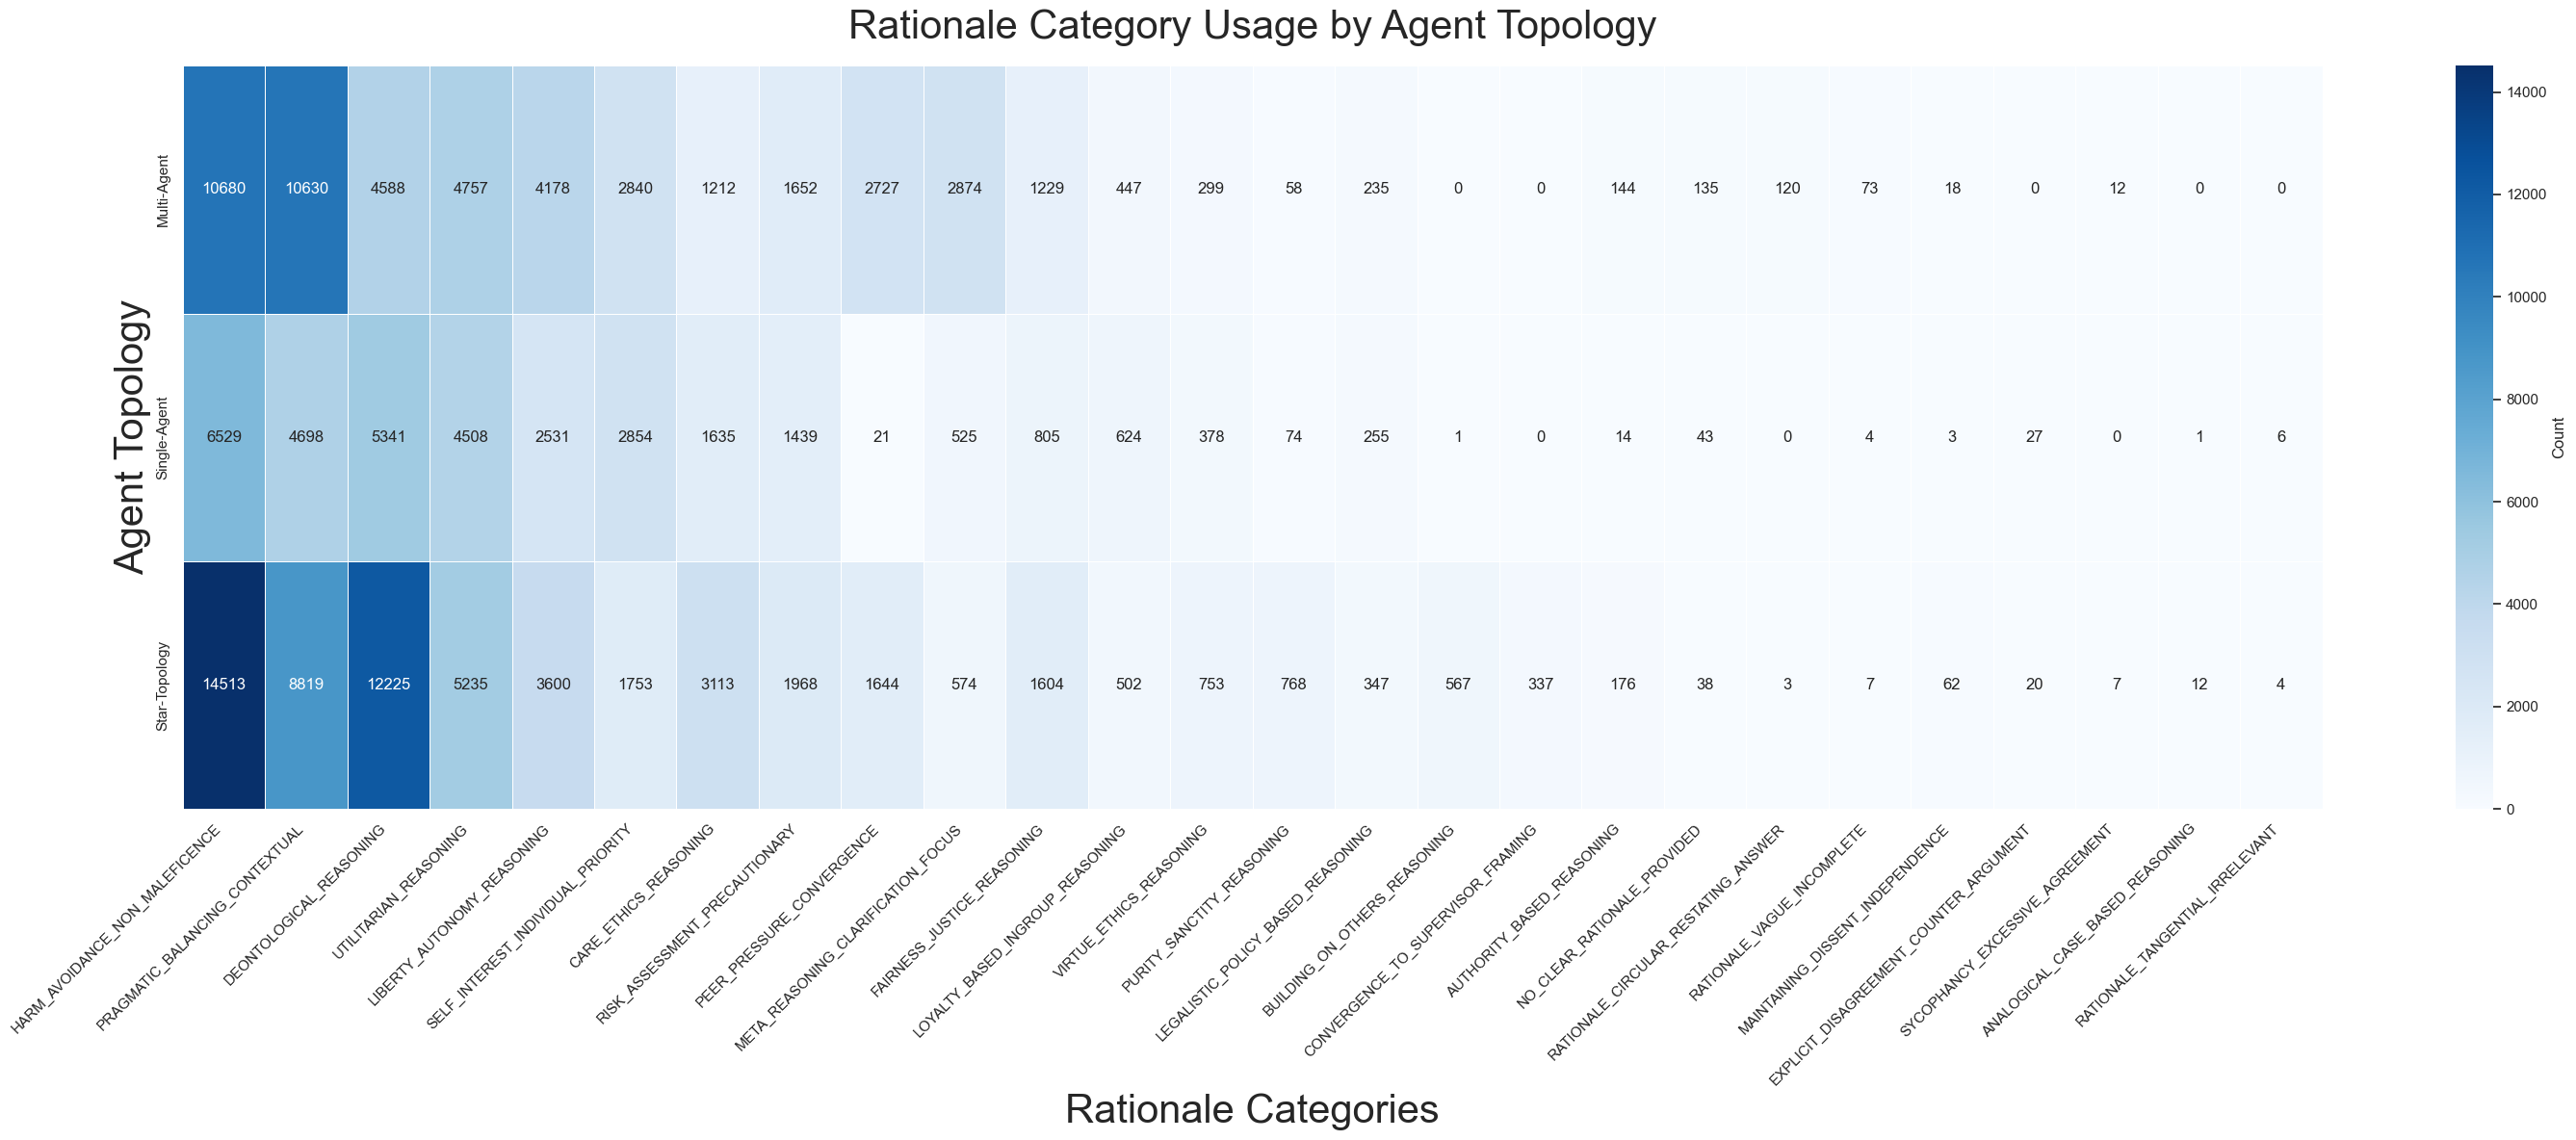


=== TOPOLOGY COMPARISON SUMMARY ===

Multi-Agent:
  Total category instances: 48908
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (10680), PRAGMATIC_BALANCING_CONTEXTUAL (10630), UTILITARIAN_REASONING (4757)

Single-Agent:
  Total category instances: 32316
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (6529), DEONTOLOGICAL_REASONING (5341), PRAGMATIC_BALANCING_CONTEXTUAL (4698)

Star-Topology:
  Total category instances: 58651
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (14513), DEONTOLOGICAL_REASONING (12225), PRAGMATIC_BALANCING_CONTEXTUAL (8819)


In [ ]:
# Clean overview heatmap: All topologies and categories
if not exploded_df.empty:
    # Create summary counts for all topologies
    topology_category_counts = exploded_df.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
    
    # Create pivot table for heatmap
    heatmap_data = topology_category_counts.pivot(
        index='topology', 
        columns='selected_categories', 
        values='count'
    ).fillna(0)
    
    # Reorder columns to match overall frequency
    col_order = exploded_df['selected_categories'].value_counts().index
    heatmap_data = heatmap_data[col_order]
    
    # Create clean overview heatmap
    plt.figure(figsize=(30, 12))
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='g', 
                cmap='Blues',
                cbar_kws={'label': 'Count'},
                linewidths=0.5)
    plt.title('Rationale Category Usage by Agent Topology', fontsize=30, pad=20)
    plt.xlabel('Rationale Categories', fontsize=30)
    plt.ylabel('Agent Topology', fontsize=30)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n=== TOPOLOGY COMPARISON SUMMARY ===")
    for topology in heatmap_data.index:
        total_categories = heatmap_data.loc[topology].sum()
        top_3_categories = heatmap_data.loc[topology].nlargest(3)
        print(f"\n{topology}:")
        print(f"  Total category instances: {int(total_categories)}")
        print(f"  Top 3 categories: {', '.join([f'{cat} ({int(count)})' for cat, count in top_3_categories.items()])}")
else:
    print("No data available for topology comparison heatmap.")

TypeError: 'numpy.ndarray' object is not callable

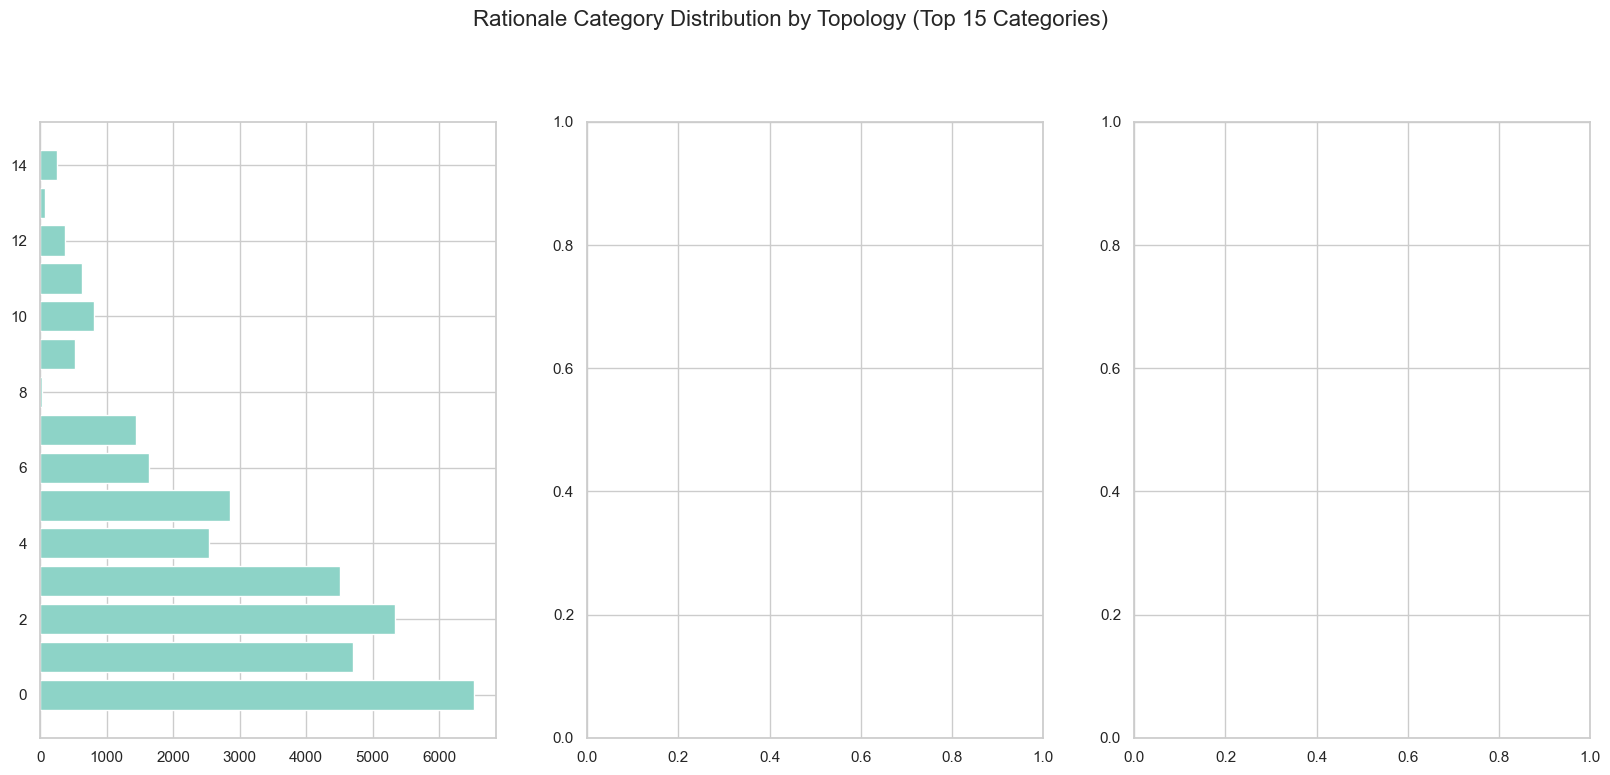

In [ ]:
# Individual topology heatmaps (clean, focused)
if not exploded_df.empty:
    # Get top 15 most frequent categories across all topologies for consistent comparison
    top_categories = exploded_df['selected_categories'].value_counts().head(15).index.tolist()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Rationale Category Distribution by Topology (Top 15 Categories)', fontsize=16, y=1.02)
    
    for idx, (topo_name, ax) in enumerate(zip(topologies.keys(), axes)):
        # Filter data for this topology
        topo_data = exploded_df[exploded_df['topology'] == topo_name]
        
        if not topo_data.empty:
            # Count categories and reindex to include all top categories
            category_counts = topo_data['selected_categories'].value_counts()
            category_counts = category_counts.reindex(top_categories, fill_value=0)
            
            # Create horizontal bar chart
            y_pos = range(len(category_counts))
            bars = ax.barh(y_pos, category_counts.values, color=plt.cm.Set3(idx))
            
            # Add value labels on bars - Fix: remove () from .values
            max_count = max(category_counts.values) if len(category_counts.values) > 0 else 1
            for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
                if count > 0:
                    ax.text(bar.get_width() + max_count * 0.01, 
                           bar.get_y() + bar.get_height()/2, 
                           f'{int(count)}', 
                           va='center', ha='left', fontsize=9)
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels([cat.replace('_', ' ').title()[:25] + ('...' if len(cat) > 25 else '') 
                               for cat in category_counts.index], fontsize=9)
            ax.set_xlabel('Count', fontsize=10)
            ax.set_title(f'{topo_name}', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            # Invert y-axis to show highest counts at top
            ax.invert_yaxis()
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{topo_name}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for individual topology charts.")

In [ ]:
# Question category analysis (if category data is available)
if not exploded_df.empty and 'category' in exploded_df.columns and len(question_categories) > 1:
    print(f"\n=== ANALYSIS BY QUESTION CATEGORY ===")
    
    # Create heatmaps for each question category across topologies
    n_categories = len(question_categories)
    n_topologies = len(topologies)
    
    # Calculate grid dimensions
    cols = min(3, n_categories)
    rows = (n_categories + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n_categories == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Rationale Categories by Question Category and Topology', fontsize=16, y=1.02)
    
    for idx, q_category in enumerate(question_categories):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        # Filter data for this question category
        q_cat_data = exploded_df[exploded_df['category'] == q_category]
        
        if not q_cat_data.empty:
            # Create topology vs rationale category counts
            category_topo_counts = q_cat_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
            
            # Get top 10 categories for this question type
            top_rationale_cats = q_cat_data['selected_categories'].value_counts().head(10).index.tolist()
            
            # Create pivot table
            pivot_data = category_topo_counts.pivot(
                index='topology', 
                columns='selected_categories', 
                values='count'
            ).fillna(0)
            
            # Filter to top categories only
            available_cats = [cat for cat in top_rationale_cats if cat in pivot_data.columns]
            if available_cats:
                pivot_data = pivot_data[available_cats]
                
                # Create heatmap
                sns.heatmap(pivot_data, 
                           annot=True, 
                           fmt='g', 
                           cmap='Blues',
                           ax=ax,
                           cbar=True,
                           linewidths=0.5)
                ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
                ax.set_xlabel('Rationale Category', fontsize=9)
                ax.set_ylabel('Topology', fontsize=9)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', rotation=0, labelsize=9)
            else:
                ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
    
    # Hide extra subplots
    for idx in range(n_categories, rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary by question category
    print("\n=== QUESTION CATEGORY SUMMARY ===")
    for q_cat in question_categories:
        q_data = exploded_df[exploded_df['category'] == q_cat]
        if not q_data.empty:
            total_responses = len(q_data)
            top_category = q_data['selected_categories'].mode().iloc[0] if len(q_data) > 0 else "None"
            unique_categories = q_data['selected_categories'].nunique()
            print(f"\n{q_cat}:")
            print(f"  Total rationale instances: {total_responses}")
            print(f"  Unique rationale types: {unique_categories}")
            print(f"  Most common rationale: {top_category}")
            
            # Distribution across topologies
            topo_dist = q_data['topology'].value_counts()
            print(f"  Topology distribution: {dict(topo_dist)}")

elif not exploded_df.empty:
    print("Question category information not available in the data.")
else:
    print("No classification data available for question category analysis.")

In [ ]:
# Comparative analysis charts
if not exploded_df.empty:
    print("\n=== COMPARATIVE ANALYSIS ===")
    
    # 1. Category diversity by topology
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    diversity_data = exploded_df.groupby('topology')['selected_categories'].nunique().sort_values(ascending=True)
    bars = plt.barh(range(len(diversity_data)), diversity_data.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.yticks(range(len(diversity_data)), diversity_data.index)
    plt.xlabel('Number of Unique Rationale Categories')
    plt.title('Rationale Diversity by Topology')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels - Fix: remove () from .values
    for i, (bar, value) in enumerate(zip(bars, diversity_data.values)):
        plt.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{int(value)}', va='center', ha='left', fontweight='bold')
    
    # 2. Top rationale categories across all topologies
    plt.subplot(1, 2, 2)
    top_overall = exploded_df['selected_categories'].value_counts().head(8)
    colors = plt.cm.Set3(range(len(top_overall)))
    bars = plt.bar(range(len(top_overall)), top_overall.values, color=colors)
    plt.xticks(range(len(top_overall)), 
               [cat.replace('_', ' ').title()[:15] + ('...' if len(cat) > 15 else '') 
                for cat in top_overall.index], 
               rotation=45, ha='right')
    plt.ylabel('Total Count')
    plt.title('Most Common Rationale Categories\n(All Topologies)')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels - Fix: remove () from .values
    max_overall = max(top_overall.values) if len(top_overall.values) > 0 else 1
    for bar, value in zip(bars, top_overall.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_overall*0.01,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Relative usage patterns (normalized by topology)
    plt.figure(figsize=(14, 8))
    
    # Calculate relative frequencies within each topology
    topology_totals = exploded_df.groupby('topology').size()
    topo_cat_counts = exploded_df.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
    topo_cat_counts['relative_freq'] = topo_cat_counts.apply(
        lambda row: row['count'] / topology_totals[row['topology']] * 100, axis=1)
    
    # Get top 12 categories by overall frequency
    top_12_cats = exploded_df['selected_categories'].value_counts().head(12).index.tolist()
    
    # Filter and pivot
    filtered_data = topo_cat_counts[topo_cat_counts['selected_categories'].isin(top_12_cats)]
    relative_pivot = filtered_data.pivot(
        index='topology', 
        columns='selected_categories', 
        values='relative_freq'
    ).fillna(0)
    
    # Reorder columns by total usage
    col_order = relative_pivot.sum().sort_values(ascending=False).index
    relative_pivot = relative_pivot[col_order]
    
    sns.heatmap(relative_pivot, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Relative Frequency (%)'},
                linewidths=0.5)
    plt.title('Relative Usage of Rationale Categories by Topology (%)', fontsize=14, pad=20)
    plt.xlabel('Rationale Categories', fontsize=12)
    plt.ylabel('Topology', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n=== KEY INSIGHTS ===")
    print("1. Rationale Diversity:")
    for topo, count in diversity_data.items():
        print(f"   {topo}: {count} unique rationale types")
    
    print(f"\n2. Most Common Overall: {top_overall.index[0]} ({top_overall.iloc[0]} instances)")
    
    print("\n3. Topology-Specific Patterns:")
    for topo in relative_pivot.index:
        top_cat_for_topo = relative_pivot.loc[topo].idxmax()
        top_freq = relative_pivot.loc[topo].max()
        print(f"   {topo}: Most used = {top_cat_for_topo} ({top_freq:.1f}%)")

else:
    print("No data available for comparative analysis.")